### Downloading the dataset
The dataset can be downloaded directly into your Google Colab environment using the [Kaggle API](https://www.kaggle.com/docs/api) as shown below. You can refer to this [post](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) on Medium for more details.

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

Upload Kaggle.json downloaded from your registered kaggle account

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

Caution (for Colab users) : Do not attempt to explore the directory using the viewer on the left as the page becomes unresponsive owing to the large size of the dataset.

### Imports

In [ ]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

### Data

In [ ]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Since the dataset is quite large, we shall create an <i>ImageDataGenerator</i> object and employ its member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. The ImageDataGenerator can also be used to dynamically apply various transformations for image augmentation which is particularly useful in the case of small datasets.

I highly encourage you to refer to the [documentation](https://keras.io/preprocessing/image/#flow_from_directory) for understanding the various parameters of the dataflow function. 

In [ ]:
INPUT_DIM =  # Image dimension
BATCH_SIZE = 
Z_DIM =  # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

### MODEL ARCHITECTURE


#### Building the Encoder

In [ ]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = 

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = # Create a conv2d module with appropriate values and arguments

      x = # use leakyrelu function here
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = # flatten output

  # Define model output
  encoder_output = # use dense function in this part

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

<br><br>
The architecture of the Encoder, as shown below, consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size 200.

In [ ]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

# use summary method to see the output of the encoder part

#### Building the Decoder


In [ ]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = 

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = # use conv2d transpose in this part
      
      if i < n_layers - 1:
        x = # use leaky relu here
      else:
        x = # use sigmoid function here

  # Define model output
  decoder_output = 

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

<br><br>
Recall that it is the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved either through the [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d) layer or the [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer.

Here, the Conv2DTranspose Layer is employed. This layer produces an output tensor double the size of the input tensor in both height and width.

<i>Note : The Decoder, in this example, is defined to be a mirror image of the encoder, which is not mandatory.</i>

<br><br>

In [ ]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
# use summary method to see the model of decoder

#### Attaching the Decoder to the Encoder

In [ ]:
simple_autoencoder_input = 

simple_autoencoder_output = 

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

# use summary method to see the model of autoencoder

### COMPILATION AND TRAINING

The loss function used is a simple Root Mean Square Error (RMSE). The true output is the same batch of images that was fed to the model at its input layer. The Adam optimizer is optimizing the RMSE error for encoding the batch of images into their respective latent vectors and subsequently decoding them to reconstruct the images. 

The ModelCheckpoint Keras callback saves the model weights for reuse. It overwrites the file with a fresh set of weights after every epoch.

NOTE : If you're using Google Colab, either download the weights to disc or mount your Google Drive.

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

# use compile method in keras to run the model

checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)


<i>TIP</i> : Here's a really useful tip I found on Reddit (by arvind1096) - to prevent Google Colab from disconnecting due to a timeout issue, execute the following JS function in the Google Chrome console. 

<br>
function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000)

In [ ]:
simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                                 callbacks=[checkpoint_ae])

### RECONSTRUCTION

The first step is to generate a new batch of images using the ImageDataGenerator defined in the 'Data' section at the top. The images are returned as an array and the number of images is equal to BATCH_SIZE. 

In [ ]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [ ]:
example_images.shape

(10, 128, 128, 3)

#### Displaying the reconstructed images

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = # use the prediction function of encoder
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = # use the prediction of decoder

  else:
    reconst_images = # complete with autoencoder function you had

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = # use the reconstruction function here
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

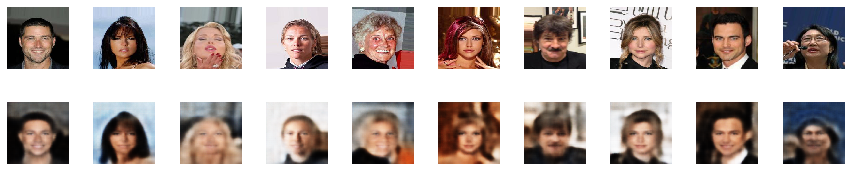

In [ ]:
plot_compare(example_images)

The first row shows images directly from the dataset and the second row shows images that have been passed through the Autoencoder. Evidently, the model has learned to encode and decode (reconstruct) fairly well. 

NOTE : A reason why the images lack sharpness is due to the RMSE loss as it averages out the differences between individual pixel values. Generative Adversarial Networks on the contrary, produce much sharper images.

## VARIATIONAL AUTOENCODER



#### Building the Encoder


In [ ]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = 

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = # use conv2d function here
      if use_batch_norm:
        x = # use batch normalization here
  
      x = # use leakyrelu function here

      if use_dropout:
        x = # use dropout with rate = 0.25 here

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = # flatten the output 
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [ ]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = # complete here with the output of VAE and summerize it

#### Building the Decoder
Since the Decoder remains the same, the Decoder architecture of the Simple Autoencoder is reused.

In [ ]:
vae_decoder_input, vae_decoder_output, vae_decoder = # use the decoder function to build decoder here and then summarize it

#### Attaching the Decoder to the Encoder


In [ ]:
#######################################################################
###### in this part you should attach and build the VAE together ######
#######################################################################
vae_input = 

vae_output = 

vae_model = 

### COMPILATION AND TRAINING


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [ ]:
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return # use total loss based on kl_loss and rl_loss

In [ ]:
adam_optimizer = # use adam optimizer

# compile model here

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [ ]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                        callbacks=[checkpoint_vae])

### RECONSTRUCTION.
The reconstruction process is the same as that of the Simple Autoencoder.

In [ ]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [ ]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

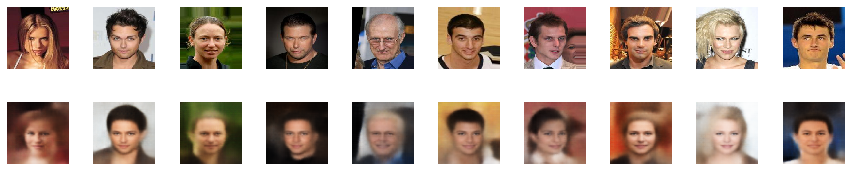

In [ ]:
plot_compare_vae(images = example_images)

### Generating new faces from random vectors sampled from a standard normal distribution. 

In [ ]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

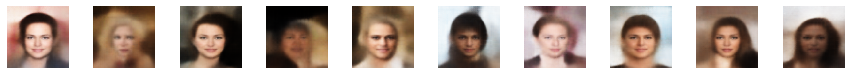

In [ ]:
vae_generate_images(n_to_show=10)